In [49]:
import numpy as np
import os
import tempfile
import keras
from keras import backend as K
from keras import layers
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
from keras.callbacks import History 
from keras.models import load_model
import matplotlib.pyplot as plt
import pickle



In [37]:
# UPLOAD DATA
# (each user should put datafiles in this directory on their computer)
datapath = "blast_tab_1hit.out"
file = open(datapath, 'r')

same_entries = []
diff_entries = []
max_length_in = 0
max_length_out = 0

for ln in file:
    toks = ln.split('\t')
    max_length_in = max(max_length_in,len(toks[2]))
    max_length_out = max(max_length_out,len(toks[3]))
    if toks[2] == toks[3]:
        same_entries.append([toks[2], toks[3]])
    else:
        diff_entries.append([toks[2], toks[3]])

file.close()
num_entries = len(same_entries) + len(diff_entries)



diff_entries_input = [entry[0] for entry in diff_entries]
diff_entries_output = [("\t" + entry[1] + "\n") for entry in diff_entries] #use '\t' as start character and '\n' as end character
#Visualize
diff_entries_output[1]
one_hot_input = {'A': 0, 'T': 1, 'C': 2, 'G': 3, '-': 4, '\t': 5, '\n': 6}
one_hot_output = {'A': 0, 'T': 1, 'C': 2, 'G': 3}

In [38]:
print(len(diff_entries_input))

58863


In [39]:
#Choose dataset size

input_seqs = diff_entries_input
output_seqs = diff_entries_output

#ENCODE
encoder_input_data = np.zeros(
    (len(input_seqs), max_length_in, len(one_hot_input)),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_seqs), max_length_out, len(one_hot_input)),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_seqs), max_length_out, len(one_hot_input)),
    dtype='float32')

for i, (input_seqs, output_seqs) in enumerate(zip(input_seqs, output_seqs)):
    for t, char in enumerate(input_seqs):
        encoder_input_data[i, t, one_hot_input[char]] = 1.
    for t, char in enumerate(output_seqs):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, one_hot_input[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, one_hot_input[char]] = 1
            
print(encoder_input_data[1,1:100, :])

[[0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.

In [114]:
#DEFINE MODEL
def define_model(num_encoder_tokens, num_decoder_tokens, latent_dim):
    #num tokens is number of words in the lexicon

    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None, num_encoder_tokens))
    encoder = LSTM(latent_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = Input(shape=(None, num_decoder_tokens))
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    return encoder_inputs, decoder_inputs, decoder_outputs

In [43]:
batch_size = 50
epochs = 10
numExamples = 7000

learning_rates = [.0001, .001, .01,]
for lr in learning_rates:
    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    encoder_inputs, decoder_inputs, decoder_outputs = define_model(num_encoder_tokens = one_hot_input,
                                                                  num_decoder_tokens = one_hot_input, 
                                                                  latent_dim = 100)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    adam = keras.optimizers.Adam(lr = lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer= adam, loss='categorical_crossentropy', metrics = ['accuracy'])

    # Run training
    history = History()

    model.fit([encoder_input_data[0:numExamples, :, :], decoder_input_data[0:numExamples, :, :]], decoder_target_data[0:numExamples, :, :],
              batch_size=batch_size,
              epochs=epochs,
              validation_split=0.2, verbose = 1,
              callbacks = [history])
    model.save('s2s_lr' + str(lr) + '.h5')
    with open('history_lr' + str(lr), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

Train on 5600 samples, validate on 1400 samples
Epoch 1/10
5600/5600 [==============================] - 345s 62ms/step - loss: 1.3851 - acc: 0.1850 - val_loss: 1.3752 - val_acc: 0.2061
Epoch 2/10
5600/5600 [==============================] - 345s 62ms/step - loss: 1.3679 - acc: 0.2126 - val_loss: 1.3580 - val_acc: 0.2211
Epoch 3/10
5600/5600 [==============================] - 339s 60ms/step - loss: 1.3501 - acc: 0.2293 - val_loss: 1.3392 - val_acc: 0.2324
Epoch 4/10
5600/5600 [==============================] - 311s 55ms/step - loss: 1.3297 - acc: 0.2362 - val_loss: 1.3163 - val_acc: 0.2354
Epoch 5/10
5600/5600 [==============================] - 263s 47ms/step - loss: 1.3031 - acc: 0.2418 - val_loss: 1.2833 - val_acc: 0.2466
Epoch 6/10
5600/5600 [==============================] - 263s 47ms/step - loss: 1.2604 - acc: 0.2490 - val_loss: 1.2211 - val_acc: 0.2490
Epoch 7/10
5600/5600 [==============================] - 261s 47ms/step - loss: 1.1621 - acc: 0.2525 - val_loss: 1.0737 - val_acc: 

C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\keras\engine\topology.py:2379: UserWarning: Layer lstm_12 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_11/while/Exit_2:0' shape=(?, 100) dtype=float32>, <tf.Tensor 'lstm_11/while/Exit_3:0' shape=(?, 100) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


Train on 5600 samples, validate on 1400 samples
Epoch 1/10
5600/5600 [==============================] - 287s 51ms/step - loss: 0.9877 - acc: 0.2582 - val_loss: 0.9825 - val_acc: 0.2553
Epoch 2/10
5600/5600 [==============================] - 273s 49ms/step - loss: 0.9814 - acc: 0.2587 - val_loss: 0.9796 - val_acc: 0.2553
Epoch 3/10
5600/5600 [==============================] - 366s 65ms/step - loss: 0.9780 - acc: 0.2587 - val_loss: 0.9761 - val_acc: 0.2580
Epoch 4/10
5600/5600 [==============================] - 767s 137ms/step - loss: 0.9733 - acc: 0.2636 - val_loss: 0.9694 - val_acc: 0.2706
Epoch 5/10
5600/5600 [==============================] - 726s 130ms/step - loss: 0.9680 - acc: 0.2682 - val_loss: 0.9641 - val_acc: 0.2740
Epoch 6/10
5600/5600 [==============================] - 754s 135ms/step - loss: 0.9602 - acc: 0.2750 - val_loss: 0.9558 - val_acc: 0.2825
Epoch 7/10
5600/5600 [==============================] - 712s 127ms/step - loss: 0.9535 - acc: 0.2792 - val_loss: 0.9528 - val_a

In [ ]:
#pickle.load(open( "history_lr0.001", "rb" ) )

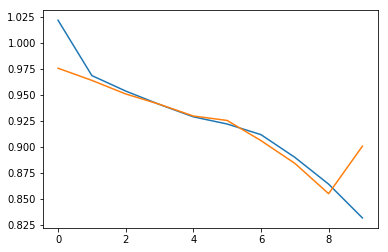

In [83]:
lr = 0.01
history = pickle.load(open('history_lr' + str(lr), "rb"))
def plot_loss(history):
    epochs = len(history["loss"])
    plt.plot(range(0, epochs), history["loss"])
    plt.plot(range(0, epochs), history["val_loss"])
plot_loss(history)

In [59]:
history_new = History()

In [111]:
def continue_train_model(model, history, model_save, history_save, lr = .01, epochs = 10, batch_size = 50):
    
    history_new = History()
    
    adam = keras.optimizers.Adam(lr = lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer= adam, loss='categorical_crossentropy', metrics = ['accuracy'])
    model.fit([encoder_input_data[0:numExamples, :, :], 
               decoder_input_data[0:numExamples, :, :]],
               decoder_target_data[0:numExamples, :, :],
                batch_size=batch_size,
                epochs=epochs,
                validation_split=0.2, 
                verbose = 1,
                callbacks = [history_new])

    #update history
    for k in history.keys():
        history[k] = history[k] + history_new.history[k]
    with open(history_save, 'wb') as file_pi:
        pickle.dump(history, file_pi)
        
    #Save model
    model.save(model_save)
    return(model, history)

Train on 5600 samples, validate on 1400 samples
Epoch 1/10
5600/5600 [==============================] - 224s 40ms/step - loss: 0.0798 - acc: 0.7747 - val_loss: 0.0685 - val_acc: 0.7723
Epoch 2/10
5600/5600 [==============================] - 229s 41ms/step - loss: 0.0707 - acc: 0.7751 - val_loss: 0.0598 - val_acc: 0.7758
Epoch 3/10
5600/5600 [==============================] - 232s 41ms/step - loss: 0.1394 - acc: 0.7452 - val_loss: 0.1471 - val_acc: 0.7368
Epoch 4/10
5600/5600 [==============================] - 234s 42ms/step - loss: 0.1315 - acc: 0.7457 - val_loss: 0.1064 - val_acc: 0.7546
Epoch 5/10
5600/5600 [==============================] - 234s 42ms/step - loss: 0.1164 - acc: 0.7536 - val_loss: 0.1231 - val_acc: 0.7497
Epoch 6/10
5600/5600 [==============================] - 186s 33ms/step - loss: 0.1119 - acc: 0.7528 - val_loss: 0.0914 - val_acc: 0.7563
Epoch 7/10
5600/5600 [==============================] - 183s 33ms/step - loss: 0.0977 - acc: 0.7573 - val_loss: 0.0834 - val_acc: 

C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\keras\engine\topology.py:2379: UserWarning: Layer lstm_12 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_11_15/while/Exit_2:0' shape=(?, 100) dtype=float32>, <tf.Tensor 'lstm_11_15/while/Exit_3:0' shape=(?, 100) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


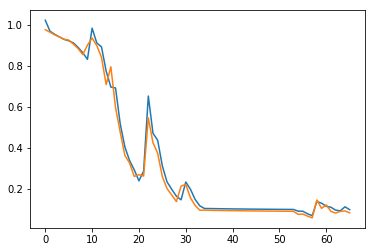

In [113]:
#Load and continue training as desired
lr = 0.001
model = load_model('s2s_lr.01_lr.001.h5')
history = pickle.load(open('history_lr.01_ly.001.h5', "rb"))

model, history = continue_train_model(model = model, history = history, model_save = ('s2s_lr.01_lr.001.h5'), history_save = ('history_lr.01_ly.001.h5'), 
                                      lr = .001, epochs = 10, batch_size = 50)
 
    
plot_loss(history)

In [116]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
# define documents
docs = encoder_input_data[0:5, :, :]

# integer encode the documents
vocab_size = 5
encoded_docs = [one_hot(d, vocab_size) for d in docs]
print(encoded_docs)


AttributeError: 'numpy.ndarray' object has no attribute 'lower'

In [ ]:
# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())
# fit the model
model.fit(padded_docs, labels, epochs=50, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))

In [ ]:

#With more latent dimensions
numExamples = 30000
batch_size = 50
epochs = 10

encoder_inputs, decoder_inputs, decoder_outputs = define_model(num_encoder_tokens = one_hot_input,
                                                                num_decoder_tokens = one_hot_input, 
                                                                latent_dim = 256)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
adam = keras.optimizers.Adam(lr = .01, beta_1=0.9, beta_2 = 0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics = ['accuracy'])
history = History()

model.fit([encoder_input_data[0:numExamples, :, :], 
               decoder_input_data[0:numExamples, :, :]],
               decoder_target_data[0:numExamples, :, :],
                batch_size=batch_size,
                epochs=epochs,
                validation_split=0.1, 
                verbose = 1,
                callbacks = [history])